# Barley Yield Prediction Model

This notebook builds a machine learning model to predict barley yield using climate and geographical features. The model incorporates seasonal climate patterns (winter, stem elongation, and grain filling periods) along with geographical coordinates to forecast agricultural productivity.

## Table of Contents

1. Library and Data Import
2. Adding Features
   - 2.1 Adding Geographical Coordinates
   - 2.2 Features for Grain Filling Period (May-June)
   - 2.3 Features for Stem Elongation Period (March-April)
   - 2.4 Features for Winter Period
   - 2.5 Feature for Technical Progress
3. Merging All Features
4. Data Preparation for Modeling
5. Linear Regression Model
6. Random Forest with Hyperparameter Optimizatio
7. Model Comparison
8. Feature Importance
9. Generating Predictions CSV


# 1. Library and Data Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


We start by loading the historical barley yield data, filtering to include only years before 2014 as historical climate data are only available before 2014

In [2]:
# Load yield data
yield_df = pd.read_csv('raw_data/barley_yield_from_1982.csv', sep=';')

# Filter data up to and including 2014
yield_df = yield_df[yield_df['year'] <= 2014].copy()

print(f"Nombre de lignes après filtrage: {len(yield_df)}")
print(f"Années: {yield_df['year'].min()} - {yield_df['year'].max()}")


Nombre de lignes après filtrage: 3168
Années: 1982 - 2014


We load the historical climate data containing temperature and precipitation measurements. This data will be aggregated into seasonal features that align with key barley growth stages.


In [3]:
# Load climate data
climate_df = pd.read_parquet('raw_data/climate_data_from_1982.parquet')

# Filter only historical scenario and years up to and including 2014
climate_df = climate_df[
    (climate_df['scenario'] == 'historical') & 
    (climate_df['year'] <= 2014)
].copy()

# Convert time to datetime
climate_df['time'] = pd.to_datetime(climate_df['time'])

# Extract month
climate_df['month'] = climate_df['time'].dt.month

print(f"Nombre de lignes de données climatiques: {len(climate_df):,}")
print(f"Années: {climate_df['year'].min()} - {climate_df['year'].max()}")
print(f"\nMétriques disponibles: {climate_df['metric'].unique()}")


Nombre de lignes de données climatiques: 3,218,151
Années: 1982 - 2014

Métriques disponibles: ['near_surface_air_temperature'
 'daily_maximum_near_surface_air_temperature' 'precipitation']


# 2. Adding Features

### 2.1 Adding Geographical Coordinates

Geographical location (latitude and longitude) is a key feature for yield prediction, as it captures regional climate patterns and soil characteristics that vary across France.

In [4]:
# Import coordinates from department_info.py
from utils.department_info import DEPARTMENT_COORDINATES

# Use DEPARTMENT_COORDINATES instead of department_coords
department_coords = DEPARTMENT_COORDINATES

# Add latitude and longitude to yield dataframe
yield_df['latitude'] = yield_df['department_number'].map(lambda x: department_coords.get(str(x).zfill(2), (None, None))[0])
yield_df['longitude'] = yield_df['department_number'].map(lambda x: department_coords.get(str(x).zfill(2), (None, None))[1])


### 2.2 Features for Grain Filling Period (May-June)

The grain filling period is critical for final yield. During this stage, we extract:
- **Hot days count**: Number of days with average temperature above 25°C (stress indicator)
- **Total precipitation**: Cumulative rainfall during this period

In [5]:
# Grain filling period: May and June

# Filter data for May and June
remplissage_df = climate_df[climate_df['month'].isin([5, 6])].copy()

# Separate temperature and precipitation
temp_remplissage = remplissage_df[remplissage_df['metric'] == 'near_surface_air_temperature'].copy()
precip_remplissage = remplissage_df[remplissage_df['metric'] == 'precipitation'].copy()

# Convert temperature from Kelvin to Celsius
temp_remplissage['temp_celsius'] = temp_remplissage['value'] - 273.15

# Convert precipitation from kg/m²/s to mm/day
precip_remplissage['precip_mm'] = precip_remplissage['value'] * 86400

# Feature 1: Number of days with average temperature > 25°C
jours_chauds = temp_remplissage[temp_remplissage['temp_celsius'] > 25].groupby(['code_dep', 'nom_dep', 'year']).size().reset_index(name='jours_temp_sup_25_remplissage')

# Feature 2: Total precipitation
somme_precip_remplissage = precip_remplissage.groupby(['code_dep', 'nom_dep', 'year'])['precip_mm'].sum().reset_index(name='somme_precip_remplissage')

# Merge grain filling features
features_remplissage = jours_chauds.merge(somme_precip_remplissage, on=['code_dep', 'nom_dep', 'year'], how='outer')

print(f"Nombre de combinaisons département-année: {len(features_remplissage)}")


Nombre de combinaisons département-année: 2937


### 2.3 Features for Stem Elongation Period (March-April)

During stem elongation, the plant structure develops. We compute:
- **Total precipitation**: Cumulative rainfall during this period
- **Average temperature**: Mean temperature for the period


In [6]:
# Stem elongation period: March and April

# Filter data for March and April
montaison_df = climate_df[climate_df['month'].isin([3, 4])].copy()

# Separate temperature and precipitation
temp_montaison = montaison_df[montaison_df['metric'] == 'near_surface_air_temperature'].copy()
precip_montaison = montaison_df[montaison_df['metric'] == 'precipitation'].copy()

# Convert temperature from Kelvin to Celsius
temp_montaison['temp_celsius'] = temp_montaison['value'] - 273.15

# Convert precipitation from kg/m²/s to mm/day
precip_montaison['precip_mm'] = precip_montaison['value'] * 86400

# Feature 1: Total precipitation
somme_precip_montaison = precip_montaison.groupby(['code_dep', 'nom_dep', 'year'])['precip_mm'].sum().reset_index(name='somme_precip_montaison')

# Feature 2: Average temperature
temp_moy_montaison = temp_montaison.groupby(['code_dep', 'nom_dep', 'year'])['temp_celsius'].mean().reset_index(name='temp_moyenne_montaison')

# Merge stem elongation features
features_montaison = somme_precip_montaison.merge(temp_moy_montaison, on=['code_dep', 'nom_dep', 'year'], how='outer')

print(f"Nombre de combinaisons département-année: {len(features_montaison)}")


Nombre de combinaisons département-année: 2937


### 2.4. Features for Winter Period

The winter period spans from December of the previous year to February of the current year. This period is important for:
- **Frost days**: Number of days with negative temperatures, which can affect plant development and survival
- **Total precipitation**: Cumulative rainfall during the winter period
- **Average temperature**: Mean temperature during the winter period


In [7]:
# Winter period: December of previous year, January and February of current year

# For each year, we take:
# - December of previous year (month=12, year-1)
# - January and February of current year (month in [1,2], year)

# Create a copy to manipulate years
hiver_df = climate_df[climate_df['month'].isin([12, 1, 2])].copy()

# For December, associate with next year (since December 1982 corresponds to winter 1982-1983, so year 1983)
hiver_df['year_for_merge'] = hiver_df.apply(
    lambda row: row['year'] + 1 if row['month'] == 12 else row['year'], 
    axis=1
)

# Separate temperature and precipitation
temp_hiver = hiver_df[hiver_df['metric'] == 'near_surface_air_temperature'].copy()
precip_hiver = hiver_df[hiver_df['metric'] == 'precipitation'].copy()

# Convert temperature from Kelvin to Celsius
temp_hiver['temp_celsius'] = temp_hiver['value'] - 273.15

# Convert precipitation from kg/m²/s to mm/day
precip_hiver['precip_mm'] = precip_hiver['value'] * 86400

# Feature 1: Number of days with negative temperature (< 0°C)
# Group by code_dep, nom_dep and year_for_merge
jours_gel = temp_hiver[temp_hiver['temp_celsius'] < 0].groupby(['code_dep', 'nom_dep', 'year_for_merge']).size().reset_index(name='jours_temp_negative_hiver')
jours_gel = jours_gel.rename(columns={'year_for_merge': 'year'})

# Feature 2: Total precipitation during winter
somme_precip_hiver = precip_hiver.groupby(['code_dep', 'nom_dep', 'year_for_merge'])['precip_mm'].sum().reset_index(name='somme_precip_hiver')
somme_precip_hiver = somme_precip_hiver.rename(columns={'year_for_merge': 'year'})

# Feature 3: Average temperature during winter
temp_moy_hiver = temp_hiver.groupby(['code_dep', 'nom_dep', 'year_for_merge'])['temp_celsius'].mean().reset_index(name='temp_moyenne_hiver')
temp_moy_hiver = temp_moy_hiver.rename(columns={'year_for_merge': 'year'})

# Create a dataframe with all department-year combinations present in the data
# to ensure we have all years even without frost days
all_combinations = temp_hiver[['code_dep', 'nom_dep', 'year_for_merge']].drop_duplicates()
all_combinations = all_combinations.rename(columns={'year_for_merge': 'year'})

# Merge all winter features
features_hiver = all_combinations.merge(jours_gel, on=['code_dep', 'nom_dep', 'year'], how='left')
features_hiver = features_hiver.merge(somme_precip_hiver, on=['code_dep', 'nom_dep', 'year'], how='left')
features_hiver = features_hiver.merge(temp_moy_hiver, on=['code_dep', 'nom_dep', 'year'], how='left')

# Fill missing values
features_hiver['jours_temp_negative_hiver'] = features_hiver['jours_temp_negative_hiver'].fillna(0).astype(int)
features_hiver['somme_precip_hiver'] = features_hiver['somme_precip_hiver'].fillna(0)
features_hiver['temp_moyenne_hiver'] = features_hiver['temp_moyenne_hiver'].fillna(0)

print(f"Nombre de combinaisons département-année: {len(features_hiver)}")


Nombre de combinaisons département-année: 3026


### 2.5 Feature for technical progess

We assume that technical progress has happennent between 1980 and 2014. To evaluate this parameter, we used an exponential formula : 
$index_{Technical Process}=1-e^{k*(t-t0)}$ 

The parameters have been estimated so that the technical Process in 1980 is 0.7 and the technical progress in 2015 is 0.95

In [8]:
# Calculate technical_index from year
# Formula: (1 - exp(-k * (t - t0)))
k = 0.0512  
t0 = 1956.5

yield_df['technical_index'] = 1 - np.exp(-k * (yield_df['year'] - t0))

# 3. Merging All Features

We combine all extracted features (geographical coordinates and seasonal climate indicators) with the yield data to create the final dataset for model training.


In [9]:
# Merge all features with yield data
print("Merging all features...")

# Create base dataframe with yield_df
dataset = yield_df[['department', 'department_number', 'year', 'yield', 'latitude', 'longitude','technical_index']].copy()

# Merge with grain filling features
dataset = dataset.merge(
    features_remplissage,
    left_on=['department_number', 'year'],
    right_on=['code_dep', 'year'],
    how='left'
)

# Merge with stem elongation features
dataset = dataset.merge(
    features_montaison,
    left_on=['department_number', 'year'],
    right_on=['code_dep', 'year'],
    how='left',
    suffixes=('', '_montaison')
)

# Merge with winter features
dataset = dataset.merge(
    features_hiver,
    left_on=['department_number', 'year'],
    right_on=['code_dep', 'year'],
    how='left',
    suffixes=('', '_hiver')
)

# Clean duplicate columns
dataset = dataset.drop(columns=['code_dep', 'nom_dep', 'code_dep_montaison', 'nom_dep_montaison', 'code_dep_hiver', 'nom_dep_hiver'], errors='ignore')

# Replace NaN values with 0 for numeric features (except yield)
feature_cols = ['jours_temp_sup_25_remplissage', 'somme_precip_remplissage', 
                'somme_precip_montaison', 'temp_moyenne_montaison', 
                'jours_temp_negative_hiver', 'somme_precip_hiver', 'temp_moyenne_hiver']
for col in feature_cols:
    if col in dataset.columns:
        dataset[col] = dataset[col].fillna(0)

print(f"Nombre de lignes dans le dataset final: {len(dataset)}")
print(f"Nombre de lignes avec toutes les features: {dataset[feature_cols].notna().all(axis=1).sum()}")
print(f"\nAperçu du dataset final:")
print(dataset.head(10))
print(f"\nColonnes du dataset: {list(dataset.columns)}")


Merging all features...
Nombre de lignes dans le dataset final: 3168
Nombre de lignes avec toutes les features: 3168

Aperçu du dataset final:
  department department_number  year    yield  latitude  longitude  \
0        Ain                01  1982  3.95008   46.2043     5.2266   
1        Ain                01  1983  2.64828   46.2043     5.2266   
2        Ain                01  1984  4.82258   46.2043     5.2266   
3        Ain                01  1985  4.19677   46.2043     5.2266   
4        Ain                01  1986  3.59845   46.2043     5.2266   
5        Ain                01  1987  4.92000   46.2043     5.2266   
6        Ain                01  1988  3.98092   46.2043     5.2266   
7        Ain                01  1989  5.03846   46.2043     5.2266   
8        Ain                01  1990  4.64400   46.2043     5.2266   
9        Ain                01  1991  5.06772   46.2043     5.2266   

   technical_index  jours_temp_sup_25_remplissage  somme_precip_remplissage  \
0      

# 4. Data Preparation for Modeling

We select the relevant features and target variable, then clean the data by removing any rows with missing values. The dataset is ready for model training.


In [10]:
# Select features and target variable
features = ['latitude', 'longitude', 'technical_index',
            'jours_temp_sup_25_remplissage', 'somme_precip_remplissage',
            'somme_precip_montaison', 'temp_moyenne_montaison', 
            'jours_temp_negative_hiver', 'somme_precip_hiver', 'temp_moyenne_hiver']

X = dataset[features].copy()
y = dataset['yield'].copy()

# Remove rows with missing values
mask = X.notna().all(axis=1) & y.notna()
X = X[mask].copy()
y = y[mask].copy()

# Keep years for temporal separation (but don't use as feature)
years = dataset.loc[mask, 'year'].copy()

# Normalize all features with StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"Nombre d'échantillons après nettoyage: {len(X)}")
print(f"Nombre de features: {len(features)}")
print(f"Features utilisées: {features}")


Nombre d'échantillons après nettoyage: 3086
Nombre de features: 10
Features utilisées: ['latitude', 'longitude', 'technical_index', 'jours_temp_sup_25_remplissage', 'somme_precip_remplissage', 'somme_precip_montaison', 'temp_moyenne_montaison', 'jours_temp_negative_hiver', 'somme_precip_hiver', 'temp_moyenne_hiver']


## 5. Linear Regression Model

We start with a baseline linear regression model to establish a performance benchmark. The data is split temporally into training (1982-2005), validation (2006-2011), and test (2011-2014) sets to respect the temporal order of the data.


In [11]:
# Temporal split into train, validation and test sets
# Train: oldest years (1982-2005)
# Validation: intermediate years (2006-2010)
# Test: most recent years (2011-2014)

# Create temporal masks
train_mask = years <= 2004
val_mask = (years > 2004) & (years <= 2009)
test_mask = years > 2009

# Split data (use X_scaled for normalized features)
X_train = X_scaled[train_mask].copy()
y_train = y[train_mask].copy()
X_val = X_scaled[val_mask].copy()
y_val = y[val_mask].copy()
X_test = X_scaled[test_mask].copy()
y_test = y[test_mask].copy()

print(f"Train set size: {len(X_train)} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X_scaled)*100:.1f}%)")
print(f"\nTotal: {len(X_train) + len(X_val) + len(X_test)} samples")

# Create and train linear regression model
print("\nTraining linear regression model...")
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)


print(f"\nTrain set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")

print(f"\nValidation set:")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\nTest set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

# Display coefficients
print(f"\n Model coefficients")
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef:.6f}")


Train set size: 2156 (69.9%)
Validation set size: 466 (15.1%)
Test set size: 464 (15.0%)

Total: 3086 samples

Training linear regression model...

Train set:
  RMSE: 0.7807
  MAE: 0.6161
  R²: 0.6865

Validation set:
  RMSE: 0.7693
  MAE: 0.6010
  R²: 0.6749

Test set:
  RMSE: 0.7881
  MAE: 0.6451
  R²: 0.6245

 Model coefficients
  latitude: 1.028715
  longitude: -0.152075
  technical_index: 0.600061
  jours_temp_sup_25_remplissage: 0.063941
  somme_precip_remplissage: 0.080955
  somme_precip_montaison: 0.120383
  temp_moyenne_montaison: 0.215580
  jours_temp_negative_hiver: -0.250988
  somme_precip_hiver: -0.151875
  temp_moyenne_hiver: -0.400870


# 6. Random Forest with Hyperparameter Optimization

Random Forest is a more sophisticated model that can capture non-linear relationships. We use RandomizedSearchCV to find optimal hyperparameters through cross-validation, balancing model complexity and generalization performance.


In [12]:
# Define hyperparameter grid to test

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV to speed up search
print("\nSearching for best hyperparameters with RandomizedSearchCV...")
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on train set
rf_search.fit(X_train, y_train)

# Display best hyperparameters
print("\n Best Hyperparameters")
best_params = rf_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest score (CV): {-rf_search.best_score_:.4f} (RMSE)")

# Use best model
rf_model = rf_search.best_estimator_

# Predictions on all sets
rf_y_train_pred = rf_model.predict(X_train)
rf_y_val_pred = rf_model.predict(X_val)
rf_y_test_pred = rf_model.predict(X_test)

# Evaluation metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_y_train_pred))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, rf_y_val_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_test_pred))
rf_train_mae = mean_absolute_error(y_train, rf_y_train_pred)
rf_val_mae = mean_absolute_error(y_val, rf_y_val_pred)
rf_test_mae = mean_absolute_error(y_test, rf_y_test_pred)
rf_train_r2 = r2_score(y_train, rf_y_train_pred)
rf_val_r2 = r2_score(y_val, rf_y_val_pred)
rf_test_r2 = r2_score(y_test, rf_y_test_pred)

print("\n Model Results")
print(f"\nTrain set:")
print(f"  RMSE: {rf_train_rmse:.4f}")
print(f"  MAE: {rf_train_mae:.4f}")
print(f"  R²: {rf_train_r2:.4f}")

print(f"\nValidation set:")
print(f"  RMSE: {rf_val_rmse:.4f}")
print(f"  MAE: {rf_val_mae:.4f}")
print(f"  R²: {rf_val_r2:.4f}")

print(f"\nTest set:")
print(f"  RMSE: {rf_test_rmse:.4f}")
print(f"  MAE: {rf_test_mae:.4f}")
print(f"  R²: {rf_test_r2:.4f}")

# Feature importance
print(f"\n Feature Importance")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))



Searching for best hyperparameters with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits



 Best Hyperparameters
  n_estimators: 200
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: None
  max_depth: None

Best score (CV): 0.4914 (RMSE)

 Model Results

Train set:
  RMSE: 0.2166
  MAE: 0.1634
  R²: 0.9759

Validation set:
  RMSE: 0.6407
  MAE: 0.5021
  R²: 0.7746

Test set:
  RMSE: 0.7350
  MAE: 0.5951
  R²: 0.6734

 Feature Importance
                      feature  importance
                     latitude    0.635421
              technical_index    0.180346
                    longitude    0.065373
       temp_moyenne_montaison    0.025176
           somme_precip_hiver    0.020789
       somme_precip_montaison    0.019648
     somme_precip_remplissage    0.018481
           temp_moyenne_hiver    0.015907
    jours_temp_negative_hiver    0.015375
jours_temp_sup_25_remplissage    0.003483


# 7. Model Comparison

We compare the performance of both models across different metrics (RMSE, MAE, R²) on training, validation, and test sets to select the best model for yield prediction.


In [13]:
# Performance comparison
comparison = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest (optimisé)'],
    'Train RMSE': [train_rmse, rf_train_rmse],
    'Val RMSE': [val_rmse, rf_val_rmse],
    'Test RMSE': [test_rmse, rf_test_rmse],
    'Train MAE': [train_mae, rf_train_mae],
    'Val MAE': [val_mae, rf_val_mae],
    'Test MAE': [test_mae, rf_test_mae],
    'Train R²': [train_r2, rf_train_r2],
    'Val R²': [val_r2, rf_val_r2],
    'Test R²': [test_r2, rf_test_r2]
})

print(comparison.to_string(index=False))

# Determine best model
models_r2 = {
    'Régression Linéaire': test_r2,
    'Random Forest': rf_test_r2
}
best_model = max(models_r2, key=models_r2.get)
best_r2 = models_r2[best_model]


                  Modèle  Train RMSE  Val RMSE  Test RMSE  Train MAE  Val MAE  Test MAE  Train R²   Val R²  Test R²
     Régression Linéaire    0.780662  0.769339   0.788132   0.616057 0.600991  0.645067  0.686547 0.674888 0.624508
Random Forest (optimisé)    0.216611  0.640653   0.734987   0.163376 0.502109  0.595121  0.975867 0.774554 0.673441


Le meilleur modèle est donc le Random Forest avec un $R^{2}$ de 0.67

## 8. Feature Importance

Highlights which features contribute most to predictions


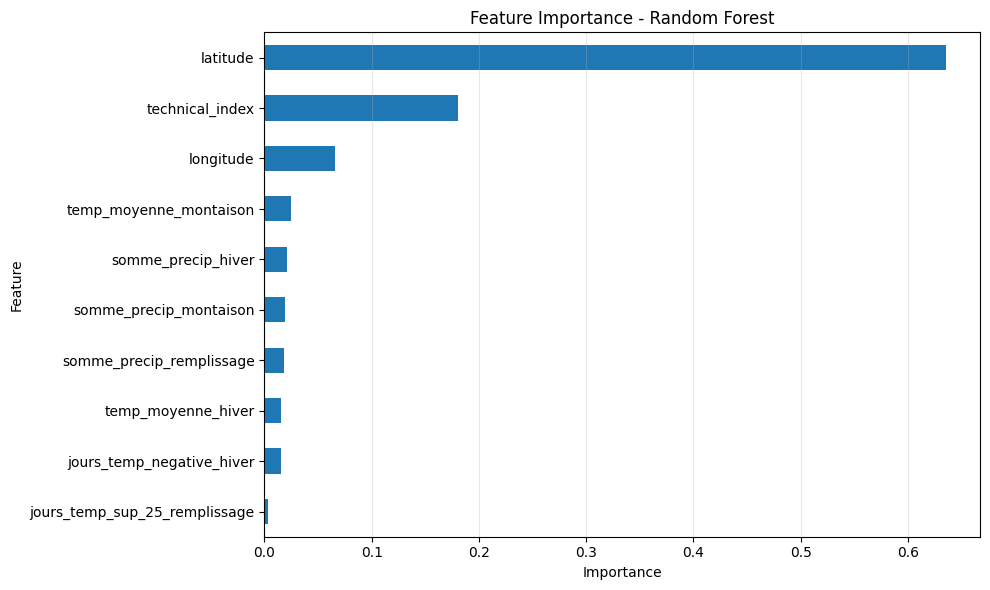

In [14]:
import matplotlib.pyplot as plt

feature_importance.sort_values('importance', ascending=True).plot.barh(
    x='feature', y='importance', legend=False, figsize=(10, 6), color='tab:blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 9. Generating Predictions CSV

We generate predictions for future years (2019-2050) across three climate scenarios (ssp1_2_6, ssp2_4_5, ssp5_8_5) and save them to a CSV file.


In [15]:
import os

# Generate CSV with predictions for 2019-2050

# Configuration
SCENARIOS = ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']
START_YEAR = 2019
END_YEAR = 2050
OUTPUT_CSV_PATH = 'data_model_prediction/predictions_yield_2019_2050.csv'

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(OUTPUT_CSV_PATH), exist_ok=True)

# 1. Load climate data for future scenarios
print("\nLoading climate data for future scenarios...")
climate_future = pd.read_parquet('raw_data/climate_data_from_1982.parquet')

# Filter for requested scenarios and years
climate_future = climate_future[
    (climate_future['scenario'].isin(SCENARIOS)) & 
    (climate_future['year'] >= START_YEAR) & 
    (climate_future['year'] <= END_YEAR)
].copy()

# Convert time to datetime and add month
climate_future['time'] = pd.to_datetime(climate_future['time'])
climate_future['month'] = climate_future['time'].dt.month


# 2. Function to calculate features for a given year and scenario
def calculate_features_for_prediction(climate_data, scenario_name, year):
    """Calculate climate features for a given year and scenario"""
    # Filter for scenario and year
    year_data = climate_data[
        (climate_data['scenario'] == scenario_name) & 
        (climate_data['year'] == year)
    ].copy()
    
    if len(year_data) == 0:
        return None
    
    # Grain filling features (May-June)
    remplissage_df = year_data[year_data['month'].isin([5, 6])].copy()
    temp_remplissage = remplissage_df[remplissage_df['metric'] == 'near_surface_air_temperature'].copy()
    precip_remplissage = remplissage_df[remplissage_df['metric'] == 'precipitation'].copy()
    
    temp_remplissage['temp_celsius'] = temp_remplissage['value'] - 273.15
    precip_remplissage['precip_mm'] = precip_remplissage['value'] * 86400
    
    jours_chauds = temp_remplissage[temp_remplissage['temp_celsius'] > 25].groupby(['code_dep', 'nom_dep']).size().reset_index(name='jours_temp_sup_25_remplissage')
    somme_precip_remplissage = precip_remplissage.groupby(['code_dep', 'nom_dep'])['precip_mm'].sum().reset_index(name='somme_precip_remplissage')
    features_remplissage = jours_chauds.merge(somme_precip_remplissage, on=['code_dep', 'nom_dep'], how='outer')
    features_remplissage['jours_temp_sup_25_remplissage'] = features_remplissage['jours_temp_sup_25_remplissage'].fillna(0).astype(int)
    
    # Stem elongation features (March-April)
    montaison_df = year_data[year_data['month'].isin([3, 4])].copy()
    temp_montaison = montaison_df[montaison_df['metric'] == 'near_surface_air_temperature'].copy()
    precip_montaison = montaison_df[montaison_df['metric'] == 'precipitation'].copy()
    
    temp_montaison['temp_celsius'] = temp_montaison['value'] - 273.15
    precip_montaison['precip_mm'] = precip_montaison['value'] * 86400
    
    somme_precip_montaison = precip_montaison.groupby(['code_dep', 'nom_dep'])['precip_mm'].sum().reset_index(name='somme_precip_montaison')
    temp_moy_montaison = temp_montaison.groupby(['code_dep', 'nom_dep'])['temp_celsius'].mean().reset_index(name='temp_moyenne_montaison')
    features_montaison = somme_precip_montaison.merge(temp_moy_montaison, on=['code_dep', 'nom_dep'], how='outer')
    
    # Winter features (December year-1, January-February year)
    hiver_df = year_data[year_data['month'].isin([1, 2])].copy()
    
    # Try to load December of previous year
    try:
        prev_year_data = climate_data[
            (climate_data['scenario'] == scenario_name) & 
            (climate_data['year'] == year - 1)
        ].copy()
        prev_year_data['time'] = pd.to_datetime(prev_year_data['time'])
        prev_year_data['month'] = prev_year_data['time'].dt.month
        decembre_prev = prev_year_data[prev_year_data['month'] == 12].copy()
        hiver_df = pd.concat([decembre_prev, hiver_df], ignore_index=True)
    except:
        pass
    
    temp_hiver = hiver_df[hiver_df['metric'] == 'near_surface_air_temperature'].copy()
    precip_hiver = hiver_df[hiver_df['metric'] == 'precipitation'].copy()
    
    temp_hiver['temp_celsius'] = temp_hiver['value'] - 273.15
    precip_hiver['precip_mm'] = precip_hiver['value'] * 86400
    
    jours_gel = temp_hiver[temp_hiver['temp_celsius'] < 0].groupby(['code_dep', 'nom_dep']).size().reset_index(name='jours_temp_negative_hiver')
    somme_precip_hiver = precip_hiver.groupby(['code_dep', 'nom_dep'])['precip_mm'].sum().reset_index(name='somme_precip_hiver')
    temp_moy_hiver = temp_hiver.groupby(['code_dep', 'nom_dep'])['temp_celsius'].mean().reset_index(name='temp_moyenne_hiver')
    
    all_combinations = temp_hiver[['code_dep', 'nom_dep']].drop_duplicates()
    features_hiver = all_combinations.merge(jours_gel, on=['code_dep', 'nom_dep'], how='left')
    features_hiver = features_hiver.merge(somme_precip_hiver, on=['code_dep', 'nom_dep'], how='left')
    features_hiver = features_hiver.merge(temp_moy_hiver, on=['code_dep', 'nom_dep'], how='left')
    
    features_hiver['jours_temp_negative_hiver'] = features_hiver['jours_temp_negative_hiver'].fillna(0).astype(int)
    features_hiver['somme_precip_hiver'] = features_hiver['somme_precip_hiver'].fillna(0)
    features_hiver['temp_moyenne_hiver'] = features_hiver['temp_moyenne_hiver'].fillna(0)

    # Merge all features
    features = features_remplissage.merge(features_montaison, on=['code_dep', 'nom_dep'], how='outer')
    features = features.merge(features_hiver, on=['code_dep', 'nom_dep'], how='outer')
    
    # Fill NaN with 0
    feature_cols = ['jours_temp_sup_25_remplissage', 'somme_precip_remplissage', 
                    'somme_precip_montaison', 'temp_moyenne_montaison', 
                    'jours_temp_negative_hiver', 'somme_precip_hiver', 'temp_moyenne_hiver']
    for col in feature_cols:
        if col in features.columns:
            features[col] = features[col].fillna(0)
    
    # Calculate technical_index for this year
    # Formula: (1 - exp(-k * (t - t0)))
    k = 0.0512  
    t0 = 1956.5
    features['technical_index'] = 1 - np.exp(-k * (year - t0))
    
    return features

# 3. Calculate predictions for each scenario and each year

all_predictions = []

for scenario in SCENARIOS:
    print(f"\nProcessing scenario: {scenario}")
    
    # Check that scenario exists
    if scenario not in climate_future['scenario'].unique():
        continue
    
    for year in range(START_YEAR, END_YEAR + 1):
        # Check that year exists in data
        if year not in climate_future[climate_future['scenario'] == scenario]['year'].unique():
            continue

        
        try:
            # Calculate features for this year and scenario
            features = calculate_features_for_prediction(climate_future, scenario, year)
            
            if features is None or len(features) == 0:
                continue
            
            # Add geographical coordinates
            features['latitude'] = features['code_dep'].map(
                lambda x: DEPARTMENT_COORDINATES.get(str(x).zfill(2), (None, None))[0]
            )
            features['longitude'] = features['code_dep'].map(
                lambda x: DEPARTMENT_COORDINATES.get(str(x).zfill(2), (None, None))[1]
            )
            
            # Prepare features for prediction (same order as during training)
            feature_cols = ['latitude', 'longitude', 'technical_index',
                            'jours_temp_sup_25_remplissage', 'somme_precip_remplissage',
                            'somme_precip_montaison', 'temp_moyenne_montaison', 
                            'jours_temp_negative_hiver', 'somme_precip_hiver', 'temp_moyenne_hiver']
            
            # Ensure all columns exist and are filled
            for col in feature_cols:
                if col not in features.columns:
                    features[col] = 0
                features[col] = features[col].fillna(0)
            
            # Filter departments with valid coordinates
            mask = features['latitude'].notna() & features['longitude'].notna()
            features_valid = features[mask].copy()
            
            if len(features_valid) == 0:
                print("(no valid department)", end='')
                continue
            
            # Prepare data for prediction
            X_pred = features_valid[feature_cols].copy()
            
            # Normalize with scaler
            X_pred_scaled = pd.DataFrame(
                scaler.transform(X_pred),
                columns=X_pred.columns,
                index=X_pred.index
            )
            
            # Perform predictions
            yield_predictions = rf_model.predict(X_pred_scaled)
            
            # Create DataFrame with results for this year and scenario
            predictions_year = pd.DataFrame({
                'department': features_valid['nom_dep'].values,
                'department_number': features_valid['code_dep'].values,
                'year': year,
                'yield_estimated': yield_predictions.round(5),
                'scenario': scenario
            })
            
            all_predictions.append(predictions_year)
            
        except Exception as e:
            print(f"Error {e}")
            continue

# 4. Merge all results
if len(all_predictions) == 0:
    print("No predictions generated")
else:
    final_df = pd.concat(all_predictions, ignore_index=True)
    
    # Sort by scenario, year, then department
    final_df = final_df.sort_values(['scenario', 'year', 'department_number']).reset_index(drop=True)
    
    # 5. Save to CSV
    print(f"\nSaving to {OUTPUT_CSV_PATH}...")
    final_df.to_csv(OUTPUT_CSV_PATH, index=False, sep=';')
    



Loading climate data for future scenarios...

Processing scenario: ssp1_2_6

Processing scenario: ssp2_4_5

Processing scenario: ssp5_8_5

Saving to data_model_prediction/predictions_yield_2019_2050.csv...
